In [186]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RXGate, XGate, ZGate, HGate
from qiskit_aer.primitives import SamplerV2
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

In [88]:
sampler = SamplerV2()

# NEQR - nucleotides as pixels

|  position $({X,Y})$  | necleotide | pixel color                   |
|----------------------|------------|-------------------------------|
|   ${0,0}$            |     A      |  $|10000000\rangle$           |
|   ${0,1}$            |     C      |  $|00110001\rangle$           |
|   ${1,0}$            |     G      |  $|00111100\rangle$           |
|   ${1,1}$            |     T      |  $|11111111\rangle$           |

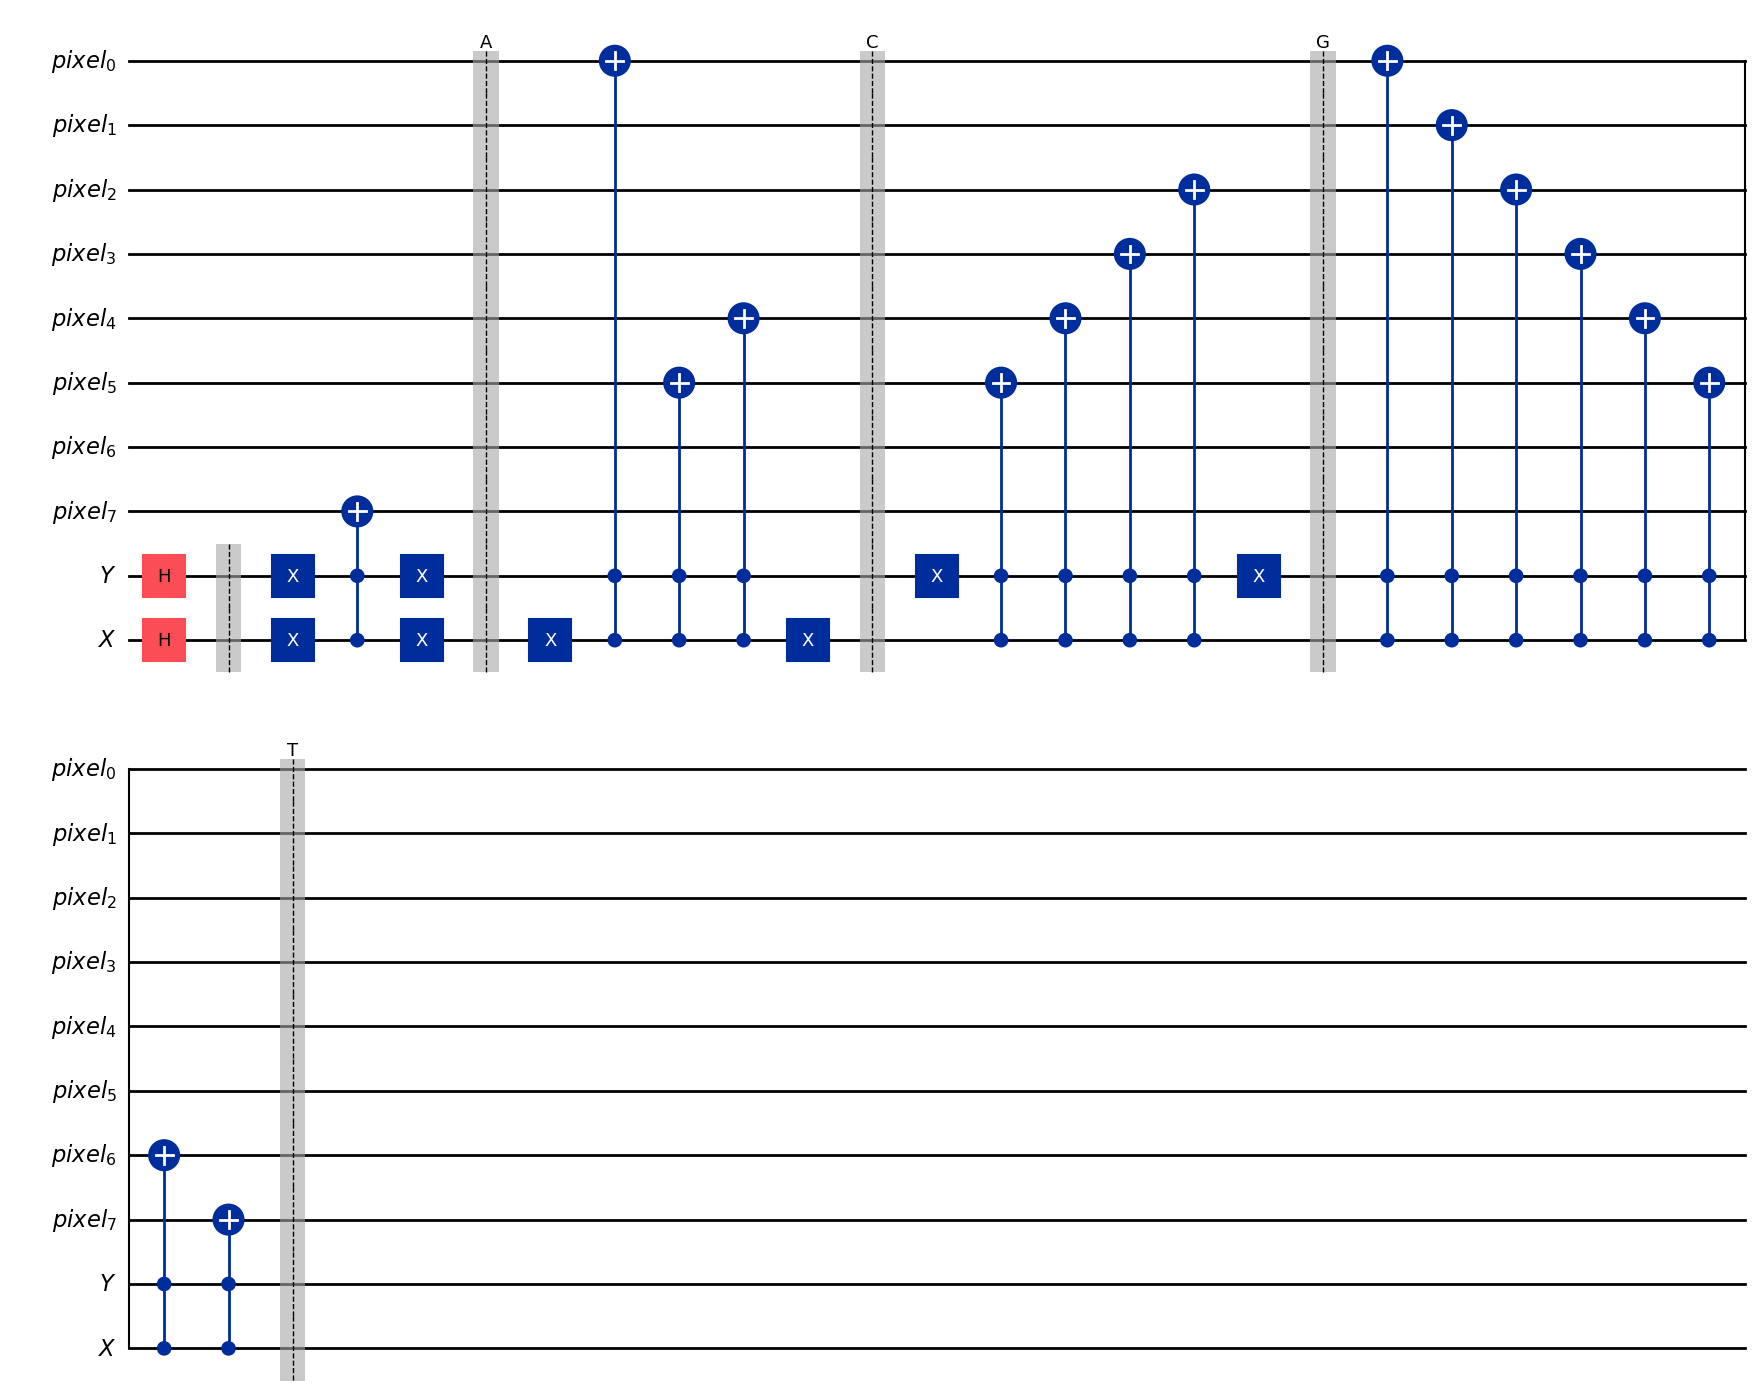

<IPython.core.display.Latex object>

In [373]:
X = QuantumRegister(1, name='X')
Y = QuantumRegister(1, name='Y')
pixels = QuantumRegister(8, name='pixel')


qc = QuantumCircuit(pixels, Y, X)

qc.h(X)
qc.h(Y)
qc.barrier(range(-1,-3,-1))

qc.x(X)
qc.x(Y)
qc.ccx(X, Y, pixels[-1])
qc.x(X)
qc.x(Y)
qc.barrier(label="A")

qc.x(X)
qc.ccx(X,Y, pixels[0])
qc.ccx(X,Y, pixels[-3])
qc.ccx(X,Y, pixels[-4])
qc.x(X)
qc.barrier(label="C")


qc.x(Y)
qc.ccx(X,Y, pixels[-3])
qc.ccx(X,Y, pixels[-4])
qc.ccx(X,Y, pixels[-5])
qc.ccx(X,Y, pixels[-6])
qc.x(Y)
qc.barrier(label="G")

for pixel in pixels:
    qc.ccx(X, Y, pixel)
qc.barrier(label="T")



display(qc.draw('mpl'))
Statevector(qc).draw('latex')

In this example, the nucleotides are encoded as 8bit grayscale color representation. The color representation was arbitraty, could be changed depending on what you want to do during processing.

# NEQR inspired bases encoding (phase encoding)

|  binary  | necleotide | phase          |
|----------|------------|----------------|
|   $00$   |     A      |  $|+\rangle$   |
|   $01$   |     C      |  $|-\rangle$   |
|   $10$   |     G      |  $|i\rangle$   |
|   $11$   |     T      |  $|-i\rangle$  |

In [190]:
CCRX = lambda theta: RXGate(theta).control(2)
CCH = HGate().control(2)

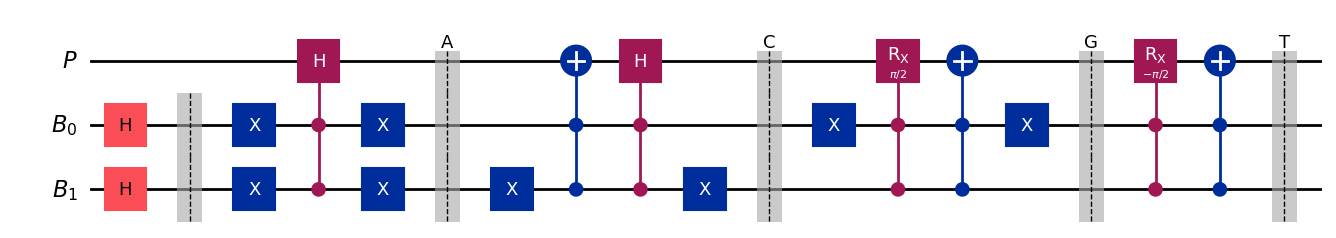

<IPython.core.display.Latex object>

In [192]:
base = QuantumRegister(2, name='B')
phase = QuantumRegister(1, name='P')

qc = QuantumCircuit(phase, base)


qc.h(base)
qc.barrier(base)

qc.x(base)
qc.append(CCH, list(range(2, -1, -1)))
qc.x(base)

qc.barrier(label="A")


qc.x(base[1])
qc.ccx(base[0], base[1], phase)
qc.append(CCH, list(range(2, -1, -1)))
qc.x(base[1])
qc.barrier(label="C")


qc.x(base[0])
qc.append(CCRX(np.pi/2), list(range(2, -1, -1)))
qc.ccx(base[0], base[1], phase)
qc.x(base[0])
qc.barrier(label="G")

qc.append(CCRX(-np.pi/2), list(range(2, -1, -1)))
qc.ccx(base[0], base[1], phase)
qc.barrier(label="T")


display(qc.draw('mpl'))
Statevector(qc).draw('latex')

This other example shows an inspired way to encode each base in a different bloch sphere basis, so it can be distinguished measuring in both `X` and `Y`. Also it can be used with different algorithms that exploits phases. 

---

# Extracting the image

In [374]:
def prepare_qc_first_method(x:int, y:int, data:dict, add_barrier:bool=True) -> QuantumCircuit:
    assert x > 0 and y > 0, "Positions should be greater than zero"

    total_pos = x+y
    XControlled = XGate().control(total_pos)
    
    X = QuantumRegister(x, name="X")
    Y = QuantumRegister(y, name="Y")
    color = QuantumRegister(8, name="Color")

    bases = {
        "A":'10000000',
        "C":'00110001',
        "G":'00111100',
        "T":'11111111'
    }
    
    qc = QuantumCircuit(color, Y, X)

    qc.h(X)
    qc.h(Y)
    
        
    for position, base in list(data.items()):

        if(add_barrier): qc.barrier()
        
        x_pos = position[:2][::-1]
        y_pos = position[-1][::-1]

        xgates_x_pos_encode = [ X[i] for i,val in enumerate(x_pos) if val == '0' ]
        xgates_y_pos_encode = [ Y[i] for i,val in enumerate(y_pos) if val == '0' ]

        has_xgates_for_xpos = len(xgates_x_pos_encode)
        has_xgates_for_ypos = len(xgates_y_pos_encode)
        
        if(has_xgates_for_xpos): qc.x(xgates_x_pos_encode)
        if(has_xgates_for_ypos): qc.x(xgates_y_pos_encode)
            
        color = bases[base]
        for bit_i, bit_val in enumerate(color[::-1]):
            if(bit_val == '0'): continue
                
            qc.append(XControlled, [*list(range(-1, -1*(total_pos+1), -1)), bit_i])
        
        if(has_xgates_for_xpos): qc.x(xgates_x_pos_encode)
        if(has_xgates_for_ypos): qc.x(xgates_y_pos_encode)

    
    return qc

In [393]:
def get_image_first_method(qc:QuantumCircuit, x:int, y:int) -> (np.array, list):
    job = sampler.run([qc], shots=1000)
    job_result = job.result()
    values = list(job_result[0].data.meas.get_counts().keys())

    colors = np.zeros((2**x,2**y))
    nucleotides = []

    for i in range(2**x):
        nucleotides.append([])
        for j in range(2**y):
            nucleotides[-1].append(' ')
    bases = {
        int('10000000',2):"A",
        int('00110001',2):"C",
        int('00111100',2):"G",
        int('11111111',2):"T"
    }

    for value in values:
        x_pos = int(value[:x],2)
        y_pos = int(value[x:x+y],2)
        color = int(value[x+y:],2)

        colors[x_pos][y_pos] = color
        if(color != 0): nucleotides[x_pos][y_pos] = bases[color]

    return colors, nucleotides

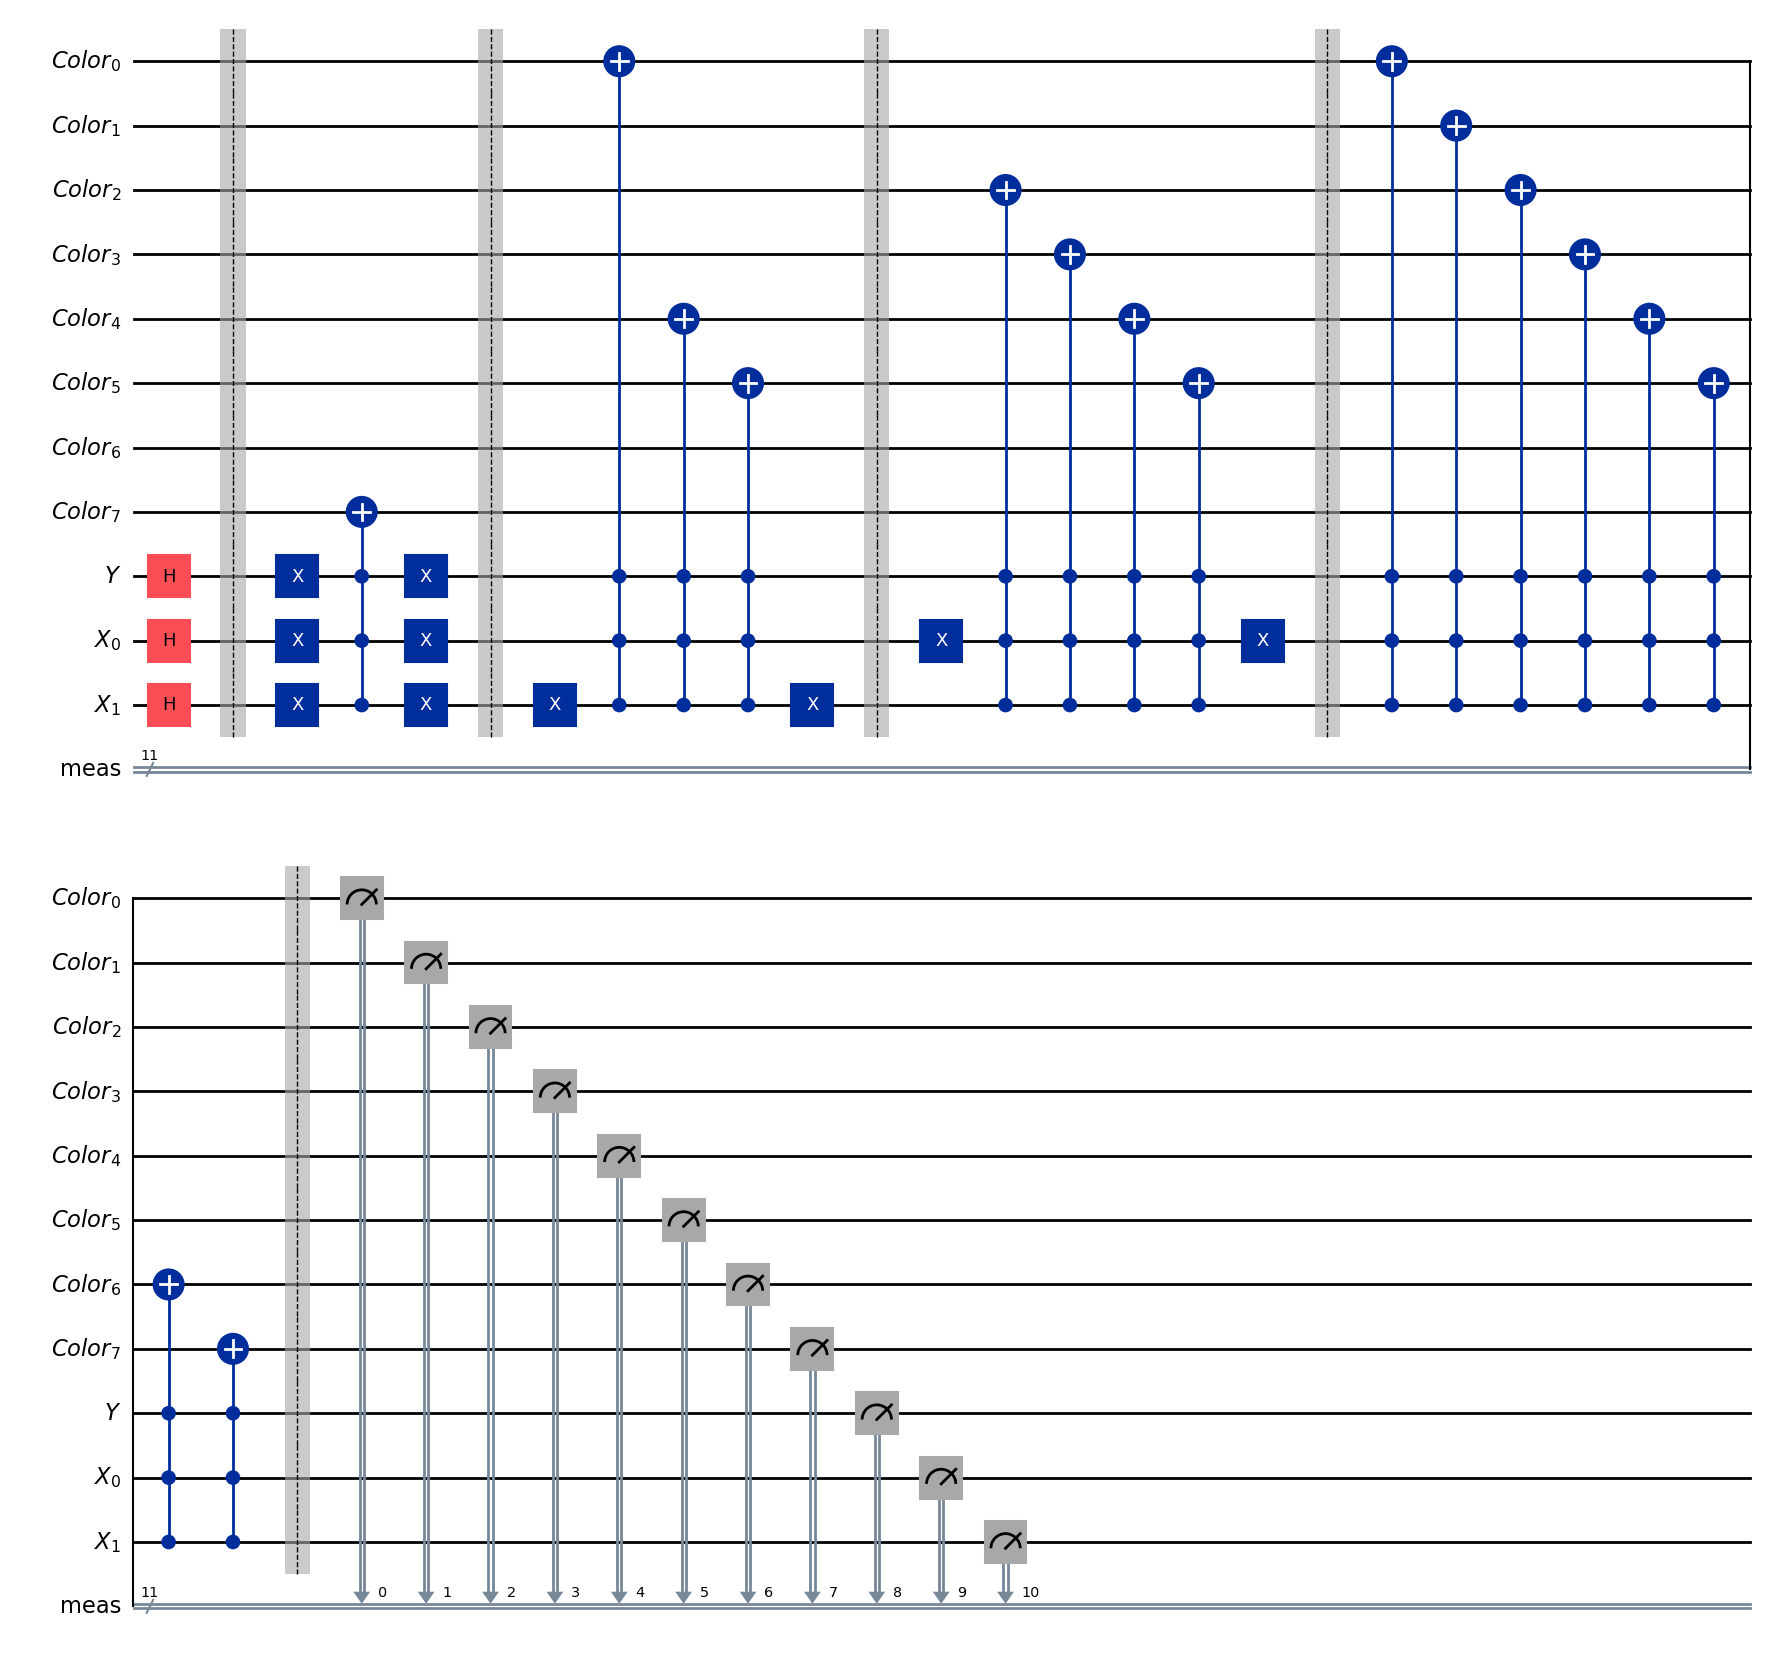

In [383]:
total_x_pos = 2
total_y_pos = 1
qc = prepare_qc_first_method(total_x_pos, total_y_pos, {'000':'A', '011':'C', '101':'G', '111':'T'})
qc.measure_all()
qc.draw('mpl')

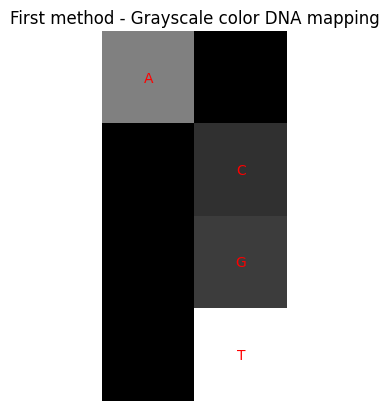

In [391]:
colors,nucleotides = get_image_first_method(qc, total_x_pos, total_y_pos)

fig, ax = plt.subplots(1, sharex = True, sharey = False)
im = ax.imshow(colors,cmap='gray')

for (j,i),_ in np.ndenumerate(colors):
    value = nucleotides[j][i]
    ax.text(i,j,value, color="red", ha='center',va='center')
plt.title("First method - Grayscale color DNA mapping")
plt.axis('Off')
plt.savefig('first-method-example.png')
plt.show()

In [229]:
def prepare_qc_second_method(x:int, y:int, data:dict, add_barrier:bool=True) -> QuantumCircuit:
    assert x > 0 and y > 0, "Positions should be greater than zero"

    total_pos = x+y
    XControlled = XGate().control(total_pos)
    HControlled = HGate().control(total_pos)
    RXControlled = lambda theta: RXGate(theta).control(total_pos)
    
    X = QuantumRegister(x, name="X")
    Y = QuantumRegister(y, name="Y")
    phase = QuantumRegister(1, name="Phase")


    def A(qc:QuantumCircuit) -> QuantumCircuit:
        qc.append(HControlled, list(range(-1, -1*(total_pos+2), -1)))
        return qc
        
    def C(qc:QuantumCircuit) -> QuantumCircuit:
        qc.append(XControlled, list(range(-1, -1*(total_pos+2), -1)))
        qc.append(HControlled, list(range(-1, -1*(total_pos+2), -1)))
        return qc
        
    def G(qc:QuantumCircuit) -> QuantumCircuit:
        qc.append(RXControlled(np.pi/2), list(range(-1, -1*(total_pos+2), -1)))
        qc.append(XControlled, list(range(-1, -1*(total_pos+2), -1)))
        return qc
        
    def T(qc:QuantumCircuit) -> QuantumCircuit:
        qc.append(RXControlled(np.pi/2), list(range(-1, -1*(total_pos+2), -1)))
        qc.append(XControlled, list(range(-1, -1*(total_pos+2), -1)))
        return qc

    bases = {
        "A":A,
        "C":C,
        "G":G,
        "T":T
    }
    
    qc = QuantumCircuit(phase, Y, X)

    qc.h(X)
    qc.h(Y)
    

    
    for position, base in list(data.items()):
        if(add_barrier): qc.barrier()
        
        x_pos = position[:2][::-1]
        y_pos = position[-1][::-1]

        xgates_x_pos_encode = [ X[i] for i,val in enumerate(x_pos) if val == '0' ]
        xgates_y_pos_encode = [ Y[i] for i,val in enumerate(y_pos) if val == '0' ]

        has_xgates_for_xpos = len(xgates_x_pos_encode)
        has_xgates_for_ypos = len(xgates_y_pos_encode)
        
        if(has_xgates_for_xpos): qc.x(xgates_x_pos_encode)
        if(has_xgates_for_ypos): qc.x(xgates_y_pos_encode)

        base_func = bases[base]
        qc = base_func(qc)
        
        if(has_xgates_for_xpos): qc.x(xgates_x_pos_encode)
        if(has_xgates_for_ypos): qc.x(xgates_y_pos_encode)


    
    return qc

In [394]:
def get_image_second_method(qc:QuantumCircuit, x:int, y:int) -> (np.array, list):
    A_C_color = [255, 180]
    G_T_color = [100, 50]
    
    colors = np.zeros((2**x,2**y))
    nucleotides = []

    for i in range(2**x):
        nucleotides.append([])
        for j in range(2**y):
            nucleotides[-1].append(' ')
    
    qc_c = qc.copy()
    qc_c.h(0)
    qc_c.measure_all()

    def get_isa(qc_:QuantumCircuit) -> QuantumCircuit:
        backend = AerSimulator()
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa = pm.run([qc_])
        return isa

    def get_measurements(qc_:QuantumCircuit) -> list:
        job = sampler.run(get_isa(qc_), shots=1000)
        job_result = job.result()
        values = list(job_result[0].data.meas.get_counts().keys())
        return values

    
    def update_colors(meas_colors:list, values:list):
        colors_ = {}
        for value in values:
            x_pos = value[:x]
            y_pos = value[x:x+y]
            val = value[x+y:]
            pos = (int(x_pos, 2), int(y_pos, 2))
            if(colors_.get(pos) == None):
                colors_[pos] = meas_colors[int(val)]
            else:
                del colors_[pos]
        return colors_

    values_X_basis = get_measurements(qc_c)
    colors_1 = update_colors(A_C_color, values_X_basis)
    
    qc_c = qc.copy()
    qc_c.rx(np.pi/2, 0)
    qc_c.measure_all()
    values_Y_basis = get_measurements(qc_c)
    
    colors_2 = update_colors(G_T_color, values_Y_basis)
    

    A_C = ('A', 'C')
    G_T = ('G', 'T')
    
    for (x,y), color in {**colors_1, **colors_2}.items():
        colors[x][y] = color
        
        if(color == 0): continue
            
        try:
            base_index = A_C_color.index(color)
            nucleotides[x][y] = A_C[base_index]
        except:
            base_index = G_T_color.index(color)
            nucleotides[x][y] = G_T[base_index]
    
    return colors, nucleotides

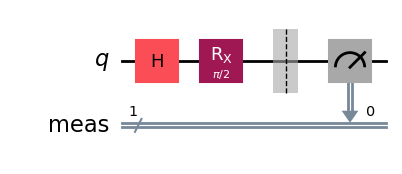

{'0': 510, '1': 514}

In [208]:
# test measuring Y

test = QuantumCircuit(1)
test.h(0)
#test.rx(np.pi/2, 0) #-np.pi/2 + Xgate == 1,  np.pi/2 + Xgate == 0
#test.x(0)
test.rx(np.pi/2, 0)
test.measure_all()

display(test.draw('mpl'))

sim = AerSimulator()
sim.run(test).result().get_counts()


<IPython.core.display.Latex object>

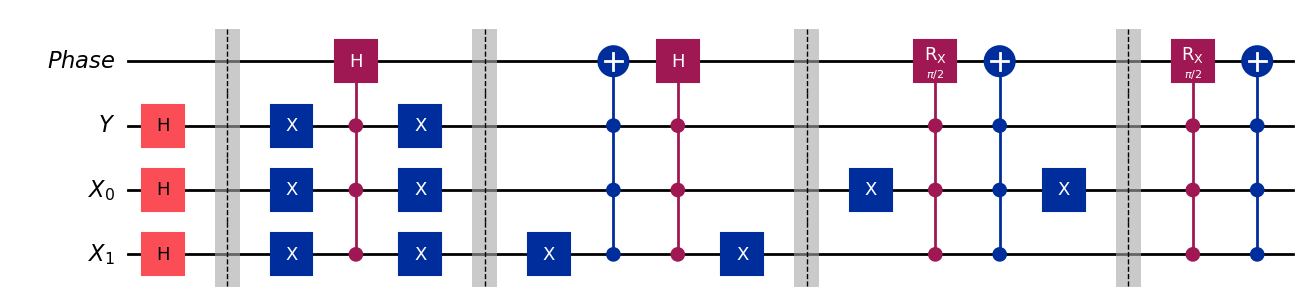

In [397]:
total_x_pos = 2
total_y_pos = 1
qc = prepare_qc_second_method(total_x_pos, total_y_pos, {'000':'A', '011':'C', '101':'G', '111':'T'})
display(Statevector(qc).draw('latex'))
qc.draw('mpl')

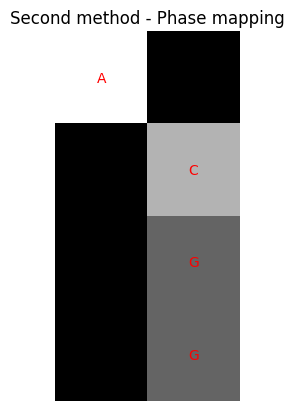

In [399]:
colors, nucleotides = get_image_second_method(qc, total_x_pos, total_y_pos)
fig, ax = plt.subplots(1, sharex = True, sharey = False)
im = ax.imshow(colors,cmap='gray')

for (j,i),_ in np.ndenumerate(colors):
    value = nucleotides[j][i]
    ax.text(i,j,value, color="red", ha='center',va='center')
plt.title("Second method - Phase mapping")
plt.axis('Off')
plt.savefig('second-method-example.png')
plt.show()

For further informations about quantum image processing, take a look at: [qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/image-processing-frqi-neqr.ipynb)